In [1]:
import yfinance as yf
import pandas as pd
import zipfile
import json
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import pickle

In [2]:
# Set directory and device
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# set directory for data and model
data_dir = 'dataset/'
model_dir = 'model/'


Device: cuda


Model Class

In [3]:
# dataset class
class StockPriceDataset(Dataset):
    def __init__(self, data, window_size, output_dim):
        self.window_size = window_size
        self.data = data
        self.output_dim = output_dim
        self.normalize()

    def normalize(self):
        self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].mean()) / self.data["daily_return"].std()

    def __len__(self):
        return len(self.data) - self.window_size + 1 - self.output_dim

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window_size -1].values # sequence of window_size - 1 days
        y = self.data.iloc[idx + self.window_size -1 : idx + self.window_size -1 + self.output_dim, -1:].values # next output_dim days
        return torch.tensor(x).float().to(device), torch.tensor(y).float().to(device)

In [4]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden_n, _) = self.lstm(x)
        
        out = self.fc(hidden_n[-1, :, :])

        return out 

In [4]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, hidden_n = self.gru(x)
        out = self.fc(hidden_n[-1, :, :])
        return out 


Loading Dataset and Trained Model

In [14]:
# Hyperparameters
input_dim = 2 # number of features
hidden_dim = 100 # number of hidden units
num_layers = 3 # number of LSTM / GRU layers
output_dim = 10 # predict next specified days of stock price
batch_size = 1

In [20]:
# load test dataset
test_dataset_name = 'test_dataset-'
# company_name = 'apple-'
company_name = 'microsoft-'
prediction_days = '10-'
path = data_dir + test_dataset_name + company_name + prediction_days + '.pkl'
with open(path, 'rb') as f:
    test = pickle.load(f)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [21]:
# load trained model

# initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
criterion = nn.MSELoss()

# load model weights
model_name = 'lstm-'
# company_name = 'apple-'
company_name = 'microsoft-'
prediction_days = "10-"
path = model_dir + model_name + company_name + prediction_days + '.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [22]:
# evaluation on test data
model.eval()
test_loss = 0.0
num_test_batches = 0
actual_values = []
predicted_values = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        targets = targets.squeeze(-1) # remove last dimension

        output = model(inputs)
        loss = criterion(output, targets)
        
        test_loss += loss.item()
        num_test_batches += 1

        # Record actual and predicted values
        actual_values.extend(targets.tolist())
        predicted_values.extend(output.tolist())

test_loss /= num_test_batches
print('Test Loss: {:.6f}'.format(test_loss))

print(actual_values[0:5])
print(predicted_values[0:5])

# rmse = sqrt(mean_squared_error(actual_values, predicted_values))
# print('RMSE: {:.6f}'.format(rmse))

Test Loss: 0.561319
[[1.2778513431549072, 0.7741201519966125, 0.7741201519966125, -1.6563305854797363, 0.8270224332809448, 0.571803629398346, 0.2699297070503235, 0.2699297070503235, -0.5892581939697266, 0.7491598725318909], [0.7741201519966125, 0.7741201519966125, -1.6563305854797363, 0.8270224332809448, 0.571803629398346, 0.2699297070503235, 0.2699297070503235, -0.5892581939697266, 0.7491598725318909, 0.1355796903371811], [0.7741201519966125, -1.6563305854797363, 0.8270224332809448, 0.571803629398346, 0.2699297070503235, 0.2699297070503235, -0.5892581939697266, 0.7491598725318909, 0.1355796903371811, 0.05521652474999428], [-1.6563305854797363, 0.8270224332809448, 0.571803629398346, 0.2699297070503235, 0.2699297070503235, -0.5892581939697266, 0.7491598725318909, 0.1355796903371811, 0.05521652474999428, 0.20715373754501343], [0.8270224332809448, 0.571803629398346, 0.2699297070503235, 0.2699297070503235, -0.5892581939697266, 0.7491598725318909, 0.1355796903371811, 0.05521652474999428, 0.

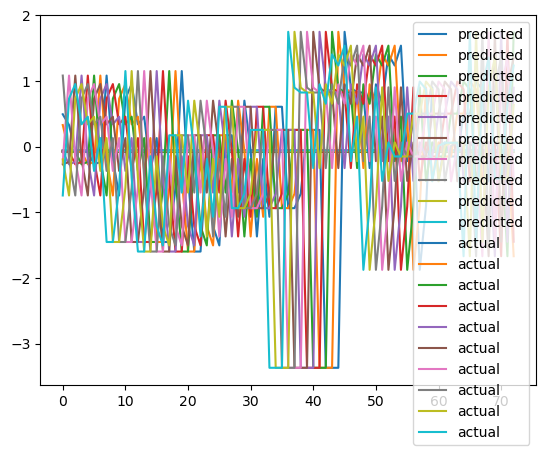

In [18]:
# plot actual vs predicted for next day 
plt.plot(predicted_values, label='predicted')
plt.plot(actual_values, label='actual')
plt.legend()
plt.show()

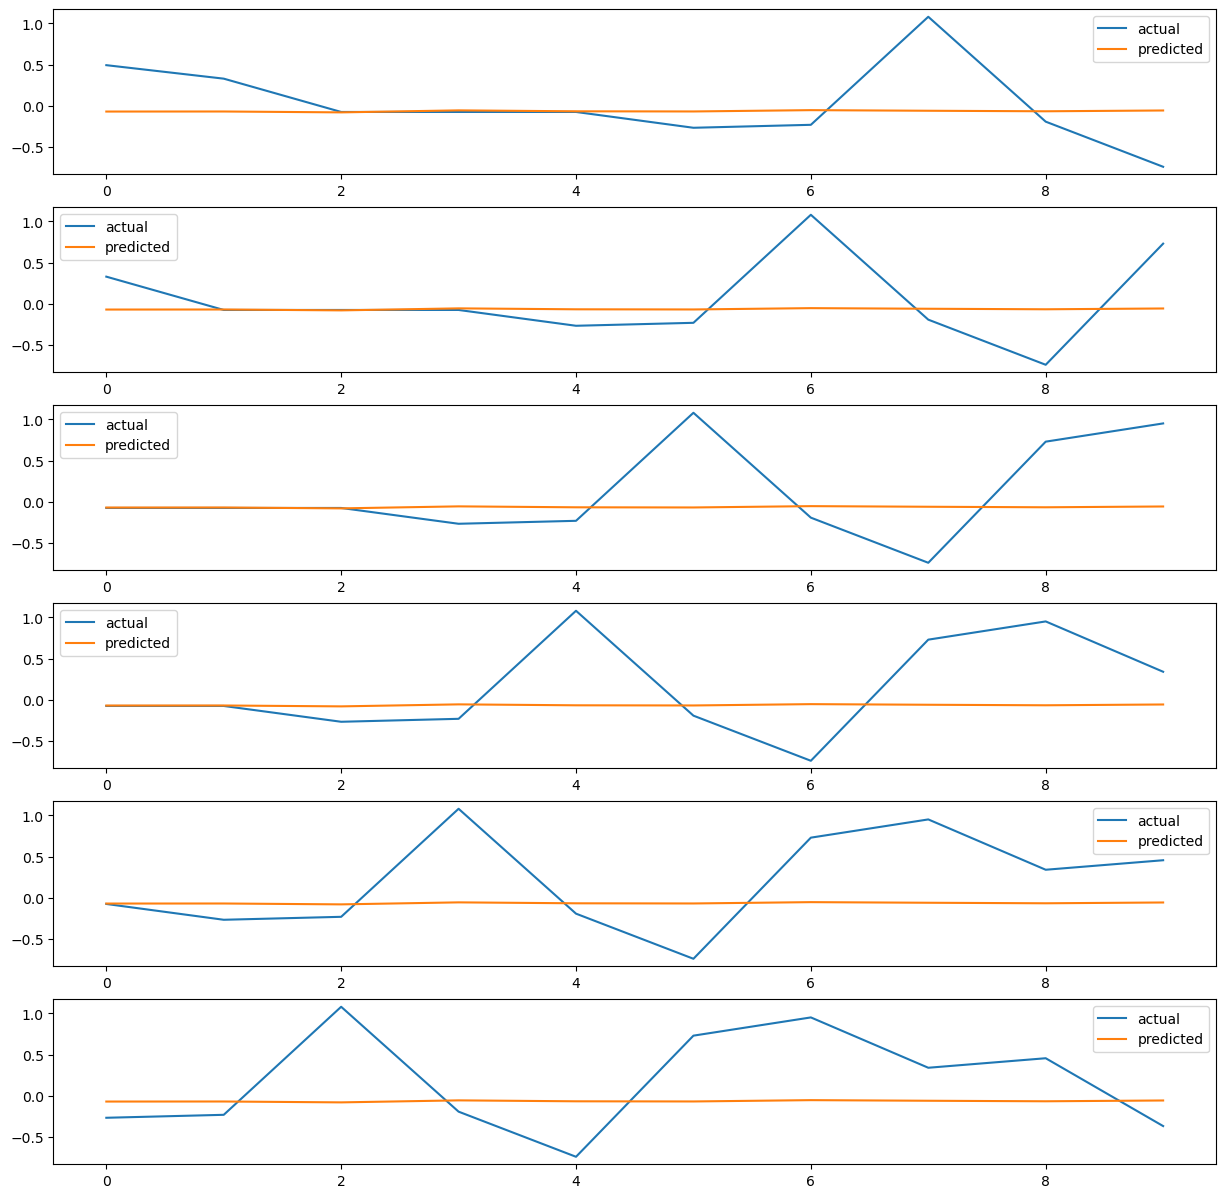

In [19]:
# Plot the first specified sequences of predictions
sequence_length_to_plot = 6
fig, axs = plt.subplots(sequence_length_to_plot, 1, figsize=(15, 15))
for i in range(min(sequence_length_to_plot, len(predicted_values))):
    axs[i].plot(actual_values[i], label='actual')
    axs[i].plot(predicted_values[i], label='predicted')
    axs[i].legend()

plt.legend()
plt.show()